In [1]:
import torch
from torch import nn

In [2]:
# torch.cuda.device_count()
device = torch.device('cuda:2') if torch.cuda.is_available() else "cpu"
device
# torch.cuda.get_device_name(device=device)

device(type='cuda', index=2)

In [3]:
from pathlib import Path



In [4]:
import os
def walk_through_directory(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



In [5]:
walk_through_directory(dir_path=data_path)

There are 9 directories and 0 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K'.
There are 0 directories and 14317 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/TUM'.
There are 0 directories and 10407 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/ADI'.
There are 0 directories and 10566 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/BACK'.
There are 0 directories and 11512 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/DEB'.
There are 0 directories and 8763 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/NORM'.
There are 0 directories and 10446 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/STR'.
There are 0 directories and 11557 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/LYM'.
There are 0 directories and 8896 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/MUC'.
There are 0 directories and 13536 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/MUS'.


Random image path: /local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/MUC/MUC-RMKPFSTR.tif
Image class: MUC
Image height: 224
Image width: 224


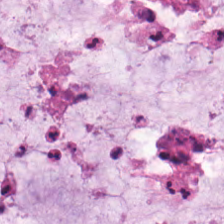

In [6]:
# Printing random image
import random
from PIL import Image

random.seed(42)

image_path_list = list(data_path.glob("*/*.tif"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [7]:
import matplotlib.pyplot as plt

In [27]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [28]:
data = datasets.ImageFolder(
    root = data_path,
    transform=data_transform
)
print(len(data))
print(data[0][0].shape, data[0][1])
print(data.classes)
print(data.class_to_idx)

100000
torch.Size([3, 64, 64]) 0
['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
{'ADI': 0, 'BACK': 1, 'DEB': 2, 'LYM': 3, 'MUC': 4, 'MUS': 5, 'NORM': 6, 'STR': 7, 'TUM': 8}


(-0.5, 223.5, 223.5, -0.5)

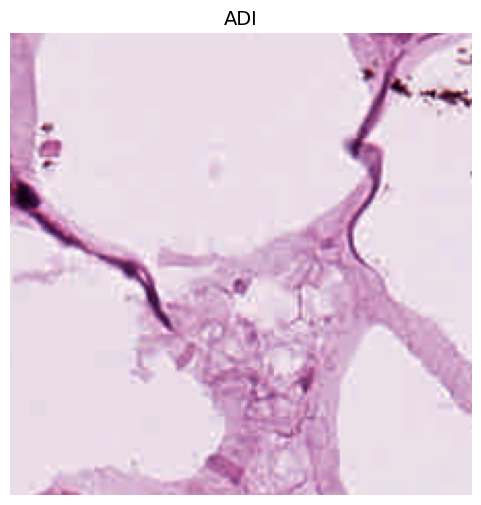

In [11]:
img_permute = data[0][0].permute(1,2,0)
fig = plt.figure(figsize=(6,6))
plt.imshow(img_permute)
plt.title(data.classes[data[0][1]], fontsize=14)
plt.axis(False)

In [12]:
train_size = int(0.8*len(data))
train_data, test_data = torch.utils.data.random_split(data, [train_size, len(data) - train_size])
print(len(train_data), len(test_data))

80000 20000


In [26]:
img, label = next(iter(train_dataloader))
print(img.shape, label.shape)

torch.Size([256, 3, 224, 224]) torch.Size([256])


In [22]:
from torch.utils.tensorboard import SummaryWriter
import torchinfo
writer = SummaryWriter()

def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [37]:
from typing import Dict, List, Tuple
from tqdm.auto import tqdm
def train_step(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> Tuple[float,float]:

    model.train()
    train_loss, train_acc = 0.0,0.0

    for batch, (x,y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float,float]:
    
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():

        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            # print(x.device)
            y_pred_logits = model(x)
            
            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item()

            y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
            test_acc += (y_pred_labels == y).sum().item()/len(y_pred_labels)
        
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc



    
# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    return results

In [17]:
IMAGE_SIZE = 64

class TinyVGG(nn.Module):
    def __init__(self, input_channels: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels = input_channels,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels= hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features = hidden_units* (IMAGE_SIZE//4) * (IMAGE_SIZE//4),
                out_features = output_shape
            )
        )

    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [31]:
#example forward pass
img, label = next(iter(test_dataloader))
img = img[0].unsqueeze(dim=0).to(device)
label = label[0]
# 
y_pred_logits = model0(img)
print("Logits: ", y_pred_logits)
y_pred_prob = torch.softmax(y_pred_logits, dim=1)
print("Prob: ", y_pred_prob)
y_pred_label = torch.argmax(y_pred_prob, dim=1)
print("Predicted label: ", y_pred_label)
print("Real Label: ", label)

Logits:  tensor([[ 8.8283, -1.4171, -1.3080, -1.0644, -1.2428, -0.8245, -1.1115, -1.2784,
         -1.2446]], device='cuda:1', grad_fn=<AddmmBackward0>)
Prob:  tensor([[9.9964e-01, 3.5508e-05, 3.9599e-05, 5.0520e-05, 4.2268e-05, 6.4219e-05,
         4.8198e-05, 4.0791e-05, 4.2191e-05]], device='cuda:1',
       grad_fn=<SoftmaxBackward0>)
Predicted label:  tensor([0], device='cuda:1')
Real Label:  tensor(0)


In [34]:
length = 50000
BATCH_SIZE = 256

indices = torch.arange(0,length)
smalldata = torch.utils.data.Subset(data, indices)
# print(nd.shape)
train_datasubset, test_datasubset = torch.utils.data.random_split(smalldata, [int(0.8*length), length - int(0.8*length)])


train_dataloader = DataLoader(
    dataset=train_datasubset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_datasubset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7fcecd0237f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fcecc978cd0>)

In [32]:

model0 = TinyVGG(input_channels=3, hidden_units=10, output_shape=9).to(device)
# torchinfo.summary(model0, (1,3,224,224))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [1]:
train(model0, train_dataloader, test_dataloader, optimizer, loss_fn, 5, device, None)

NameError: name 'train' is not defined

In [39]:
len(data)

100000

In [29]:
ts = int(0.8*100)
indices = torch.arange(0,100)
nd = torch.utils.data.Subset(data, indices)
# print(nd.shape)
trdata, tedata = torch.utils.data.random_split(nd, [80,20])
print(len(trdata), len(tedata))

BATCH_SIZE = 256


# new_train = train_data[:100]

dodo_train = DataLoader(
    dataset=trdata,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# new_test = test_data[:100]

dodo_test = DataLoader(
    dataset=tedata,
    batch_size=BATCH_SIZE,
    shuffle=False
)

dodo_train, dodo_test

res = train(model0, dodo_train, dodo_test, optimizer, loss_fn, 10, device, None)

80 20


 20%|██        | 2/10 [00:00<00:01,  5.01it/s]

cuda:1
Epoch: 1 | train_loss: 2.2048 | train_acc: 0.0000 | test_loss: 1.7006 | test_acc: 1.0000
cuda:1
Epoch: 2 | train_loss: 1.6993 | train_acc: 1.0000 | test_loss: 0.0567 | test_acc: 1.0000


 40%|████      | 4/10 [00:00<00:00,  6.61it/s]

cuda:1
Epoch: 3 | train_loss: 0.0545 | train_acc: 1.0000 | test_loss: 0.0009 | test_acc: 1.0000
cuda:1
Epoch: 4 | train_loss: 0.0008 | train_acc: 1.0000 | test_loss: 0.0007 | test_acc: 1.0000


 60%|██████    | 6/10 [00:00<00:00,  7.13it/s]

cuda:1
Epoch: 5 | train_loss: 0.0007 | train_acc: 1.0000 | test_loss: 0.0006 | test_acc: 1.0000
cuda:1
Epoch: 6 | train_loss: 0.0006 | train_acc: 1.0000 | test_loss: 0.0006 | test_acc: 1.0000


 80%|████████  | 8/10 [00:01<00:00,  7.39it/s]

cuda:1
Epoch: 7 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 0.0005 | test_acc: 1.0000
cuda:1
Epoch: 8 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 0.0005 | test_acc: 1.0000


100%|██████████| 10/10 [00:01<00:00,  6.77it/s]

cuda:1
Epoch: 9 | train_loss: 0.0004 | train_acc: 1.0000 | test_loss: 0.0004 | test_acc: 1.0000
cuda:1
Epoch: 10 | train_loss: 0.0004 | train_acc: 1.0000 | test_loss: 0.0004 | test_acc: 1.0000


In [21]:
# torch.cuda.get_device_properties(device)
device

device(type='cuda', index=1)

In [36]:
torch.cuda.empty_cache()

In [ ]:
from pathlib import Path
save_path = Path("models/")
torch.save(model.state_dict(), PATH)

In [4]:
import froodo

In [1]:
from froodo.quickstart import *
# Printing random image
import random
from PIL import Image
from pathlib import Path

data_path = Path("/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/")

random.seed(42)

image_path_list = list(data_path.glob("*/*.tif"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

aug = DarkSpotsAugmentation()

Random image path: /local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/MUC/MUC-RMKPFSTR.tif
Image class: MUC
Image height: 224
Image width: 224


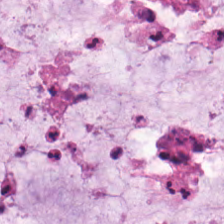

In [16]:
img

In [9]:
s = Sample(image=torch.tensor(np.asarray(img)).permute(2,0,1))

In [8]:
torch.tensor(np.asarray(img)).permute(2,0,1).shape

torch.Size([3, 224, 224])

In [ ]:
Image.fromarray(s.image.numpy())

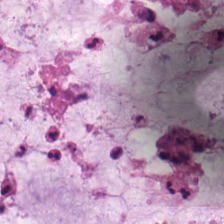

In [28]:
s = Sample(image=torch.tensor(np.asarray(img)).permute(2,0,1))
augs = [DarkSpotsAugmentation(1), FatAugmentation(1), SquamousAugmentation(1), ThreadAugmentation(1), GaussianBlurAugmentation(sigma=5)]
Image.fromarray(random.choice(augs)(s).image.permute(1,2,0).numpy())

In [19]:
s.image

tensor([[[ 56,  54,  57,  ..., 183, 185, 201],
         [ 55,  55,  56,  ..., 186, 181, 198],
         [ 57,  57,  56,  ..., 184, 176, 193],
         ...,
         [ 82,  83,  81,  ..., 189, 200, 202],
         [ 85,  82,  82,  ..., 183, 195, 206],
         [ 89,  83,  85,  ..., 188, 205, 214]],

        [[ 42,  41,  46,  ..., 151, 154, 171],
         [ 42,  44,  47,  ..., 150, 144, 165],
         [ 47,  48,  46,  ..., 147, 135, 154],
         ...,
         [ 74,  74,  73,  ..., 155, 167, 170],
         [ 78,  73,  73,  ..., 146, 160, 176],
         [ 81,  74,  75,  ..., 153, 171, 190]],

        [[ 53,  52,  55,  ..., 188, 191, 205],
         [ 53,  53,  55,  ..., 187, 183, 196],
         [ 56,  56,  54,  ..., 180, 171, 185],
         ...,
         [ 82,  82,  80,  ..., 183, 194, 197],
         [ 85,  82,  81,  ..., 179, 190, 202],
         [ 88,  83,  84,  ..., 184, 201, 212]]], dtype=torch.uint8)

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

data = datasets.ImageFolder(
        root = data_path,
        transform = transforms.ToTensor()
    )


In [7]:
type(data[0])

tuple

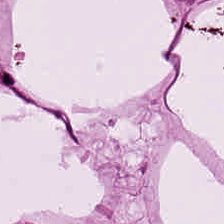

In [53]:
Image.fromarray((data[0][0] * 255).permute(1,2,0).numpy().astype(np.uint8))

In [55]:
augs = [DarkSpotsAugmentation(1), FatAugmentation(1), SquamousAugmentation(1), ThreadAugmentation(1), GaussianBlurAugmentation(sigma=5)]
data[0] = (random.choice(augs)(Sample(data[0][0])), data[0][1])
Image.fromarray((data[0][0] * 255).permute(1,2,0).numpy().astype(np.uint8))

TypeError: 'ImageFolder' object does not support item assignment